# Adaption to new classes
project 7 by Guanzhao Wang, Haochen Wu, Yukai Wang

### Abstact outline:
In this project, the goal is to find a way for supervised classification neural network to generalize on unlabeled data with unseen features. In particular, among all possible labels for a specific dataset, some of them do not have any labeled entries. This notebook provides a comparison of several methods we attempt to train the network utilizing the unlabeled data so that it can generalize to classifying more categories.

We use Fashion-MNIST dataset and manually remove the labels for certain categories to simulate the scenario. Then we utilize those unlabeled data by applying several unsupervised clustering methods. Such methods are implemented in `mylibs` and compared at the end of the notebook. The classification model will be trained with both labeled data and unlabeled data labeled by the clustering methods. We conclude that some of the approaches can significantly improve the models which are comparable to fully supervised models.

### Teammates:
- Guanzhao Wang: Implement clustering algorithms and Variational Auto Encoder

- Haochen Wu: Implement whole flow training, dataloaders, and report plots

- Yukai Wang: Implement training models, transforms and documentation

### Library
Several library functions are implemented. They are imported in the front of the next code block. The externel libraries are imported in the behind of the next block.

Our own code library is implemented in the <em>mylib</em> subdirectory. All the files in the library are listed below in an order used to train models:
- <strong>dataloader</strong>: 
>Include customFashionMNIST class for loading custom Fashion-MNIST dataset. Dataloader functions: <br><code>getTrainValidateLoaders(include_labels=range(10), transform=None, batch_size=64, split = 0.9, num_workers=1, mode=7, USE_GPU=False)</code>
     <br><code>getTestLoaders(include_labels=range(10), transform=None, batch_size=64, num_workers=1, USE_GPU=False)</code>
- <strong>transform</strong>: 
>Define transform used for dataloader. 
- <strong>model</strong>: 
>Include several Neural Networks. A normal CNN: <code>Net()</code>, <br>A ResNet model: <code>CustomFashionResNet()</code>, <br>clustering model: <code>Autoencoder()</code>
- <strong>loss</strong>: 
>Include loss functions. <br>crossEntropyLoss for training: <code>loss_function()</code>; <br>loss for autoencoder: <code>autoencoder_loss()</code>
- <strong>train</strong>: 
>Train functions for models and autoencoder: <br><code>train(train_val_loaders, net, loss_function, optimizer, USE_GPU, checkpoint_path)</code> and <br><code>autoencoder_train(train_loader, net, loss_function, optimizer, USE_GPU)</code>
- <strong>eval</strong>: 
>Include validation function: <code>validate(val_loader, net, loss, USE_GPU)</code>
- <strong>clustering</strong>: 
>Unsupervised method for labeling data. <code>label_data(unlabeled_data, labels, mode=0, USE_GPU=False)</code>
- <strong>report</strong>: 
>Three report functions. <br>Training report: <code>report_epoch_summary(eval_metrics)</code>; <br>Summary report: <code>report_summary(mode_metrics, mode_description)</code>; <br>Test report: <code>report_test_summary(mode_metrics, mode_description)</code>

Externel libraries included:
- <strong>numpy</strong>:
- <strong>matplotlib</strong>: 
><br><code>matplotlib.pyplt</code>
- <strong>torch</strong>:
- <strong>torchvision</strong>:
- <strong>sklearn</strong>: 
>in clustering, for Kmean and GaussianMixture, confusion_matrix
- <strong>pl_bolts.models.autoencoders</strong>: 
><code>pip install lightning-bolts</code>

In [1]:
from mylibs.dataloader import getTrainValidateLoaders, getTestLoaders, CustomFashionMNIST
from mylibs.train import train
from mylibs.eval import validate
from mylibs.model import Net, CustomFashionResNet
from mylibs.loss import loss_function
from mylibs.report import report_epoch_summary, report_summary, report_test_summary
from mylibs.transform import transform_t, transform_n, transform_aug
from mylibs.clustering import label_data

import numpy as np
import torch
import torchvision
from torchvision import transforms
import os

In [2]:
USE_GPU = True
BATCH_SIZE = 64
EPOCH = 30
NUM_WORKERS = 2
K = 7

In [3]:
device = torch.device("cuda" if USE_GPU else "cpu")

transform = transform_t

mode_description = {0: "clustering: kmeans",
                    1: "clustering: kmeans with PCA",
                    2: "clustering: kmeans with Auto Encoder",
                    3: "clustering: Gaussian Mixture",
                    4: "clustering: Gaussian Mixture with PCA",
                    5: "clustering: Gaussian Mixture with Auto Encoder",
                    6: "use only labeled data",
                    7: "use full FasionMNIST data",
                   }

mode_description_short = {0: "Kmeans",
                          1: "Kmeans with PCA",
                          2: "Kmeans with Auto Encoder",
                          3: "Gaussian Mixture",
                          4: "Gaussian Mixture with PCA",
                          5: "Gaussian Mixture with Auto Encoder",
                          6: "Labeled data only",
                          7: "Full FasionMNIST",
                         }

mode_metrics = {}
mode_test_metrics = {}

In [26]:
def whole_flow(mode, useResnet):
    global mode_metrics
    print(f"Getting train and validate dataloaders for mode {mode}: {mode_description[mode]}")
    train_val_loaders = getTrainValidateLoaders(include_labels=range(K), transform=transform, batch_size=BATCH_SIZE, split=0.9, num_workers=NUM_WORKERS, mode=mode, USE_GPU=USE_GPU)
    if useResnet:
        model = CustomFashionResNet(color_scale = 1, num_classes = 10).to(device)
    else:
        model = Net().to(device)
    optimizer = torch.optim.Adadelta(model.parameters(), lr=0.01)
    eval_metrics = []

    model_name = "ResNet" if useResnet else "Net"
    checkpoint_path = f"./checkpoint/mode_{mode}/{model_name}"
    os.makedirs(checkpoint_path, exist_ok=True)
    
    print(f"Start Training... {model_name}")
    # scheduler = StepLR(optimizer, step_size=1, gamma=args.gamma)
    for epoch in range(1, EPOCH+1):
        eval_metric = train(train_val_loaders, model, loss_function, optimizer, USE_GPU, f"{checkpoint_path}/epoch_{epoch}.pt")
        eval_metrics.append(eval_metric)
        print(f"Epoch: {epoch}")
        print(f"\tTrain      - Loss: {eval_metric['train']['loss']:.4f} Accuracy: {eval_metric['train']['acc']:.4f} F1_score: {eval_metric['train']['f1']:.4f}")
        print(f"\tValidation - Loss: {eval_metric['val']['loss']:.4f} Accuracy: {eval_metric['val']['acc']:.4f} F1_score: {eval_metric['val']['f1']:.4f}")

    report_epoch_summary(eval_metrics)
    
    all_val_f1 = [x['val']['f1'] for x in eval_metrics]
    best_epoch = all_val_f1.index(max(all_val_f1)) + 1
    print(f"Loading model at epoch {best_epoch} for best validation f1")
    checkpoint = torch.load(f"{checkpoint_path}/epoch_{epoch}.pt")
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    
    print("Preparing test loaders")
    labeled_test_loader, unlabeled_test_loader, test_loader = getTestLoaders(include_labels=range(K), transform=transform, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, USE_GPU=USE_GPU)
    
    model.eval()
    eval_metric = validate(labeled_test_loader, model, loss_function, USE_GPU)
    print(f"Result on labelled test set  : Loss: {eval_metric['loss']:.4f} Accuracy: {eval_metric['acc']:.4f} F1_score: {eval_metric['f1']:.4f}")

    eval_metric = validate(unlabeled_test_loader, model, loss_function, USE_GPU)
    print(f"Result on unlabelled test set: Loss: {eval_metric['loss']:.4f} Accuracy: {eval_metric['acc']:.4f} F1_score: {eval_metric['f1']:.4f}")

    eval_metric = validate(test_loader, model, loss_function, USE_GPU)
    print(f"Result on full test set      : Loss: {eval_metric['loss']:.4f} Accuracy: {eval_metric['acc']:.4f} F1_score: {eval_metric['f1']:.4f}")
    
    mode_metrics[mode] = eval_metrics
    mode_test_metrics[mode] = eval_metric
    
def clustering_acc():
    include_labels = range(K)
    exclude_labels = np.arange(10)[~np.isin(np.arange(10), include_labels)]

    test_set = CustomFashionMNIST(train=False, include_labels=range(10), transform=transform, mode=7,USE_GPU=USE_GPU)
    labeled_test_set = [(img,label) for img, label in test_set if label in include_labels]
    unlabeled_test_set = [(img,label) for img, label in test_set if label not in include_labels]
    data = [(img,label) for img, label in test_set]

    print("- Unsupervised Clusteriing on the full test set:")
    full = label_data(data, labels=np.arange(10), all_data=test_set, mode=0, USE_GPU=USE_GPU)
    print("- Unsupervised Clusteriing on the labelled test set:")
    labelled = label_data(labeled_test_set, labels=np.arange(K), all_data=test_set, mode=0, USE_GPU=USE_GPU)
    print("- Unsupervised Clusteriing on the unlabelled test set:")
    unlabelled = label_data(unlabeled_test_set, labels=exclude_labels, all_data=test_set, mode=0, USE_GPU=USE_GPU)

## Baseline #1, use only first K-class labelled data to train

Getting train and validate dataloaders for mode 6: use only labeled data
Start Training... Net
Epoch: 1
	Train      - Loss: 0.6015 Accuracy: 0.7887 F1_score: 0.7864
	Validation - Loss: 0.4646 Accuracy: 0.8293 F1_score: 0.8265
Epoch: 2
	Train      - Loss: 0.4213 Accuracy: 0.8460 F1_score: 0.8449
	Validation - Loss: 0.4144 Accuracy: 0.8479 F1_score: 0.8441
Epoch: 3
	Train      - Loss: 0.3751 Accuracy: 0.8629 F1_score: 0.8620
	Validation - Loss: 0.3797 Accuracy: 0.8629 F1_score: 0.8625
Epoch: 4
	Train      - Loss: 0.3458 Accuracy: 0.8757 F1_score: 0.8750
	Validation - Loss: 0.3704 Accuracy: 0.8664 F1_score: 0.8658
Epoch: 5
	Train      - Loss: 0.3230 Accuracy: 0.8844 F1_score: 0.8839
	Validation - Loss: 0.3516 Accuracy: 0.8752 F1_score: 0.8738
Epoch: 6
	Train      - Loss: 0.3062 Accuracy: 0.8902 F1_score: 0.8897
	Validation - Loss: 0.3464 Accuracy: 0.8721 F1_score: 0.8732
Epoch: 7
	Train      - Loss: 0.2910 Accuracy: 0.8974 F1_score: 0.8969
	Validation - Loss: 0.3334 Accuracy: 0.8829 F1_sc

<Figure size 432x288 with 0 Axes>

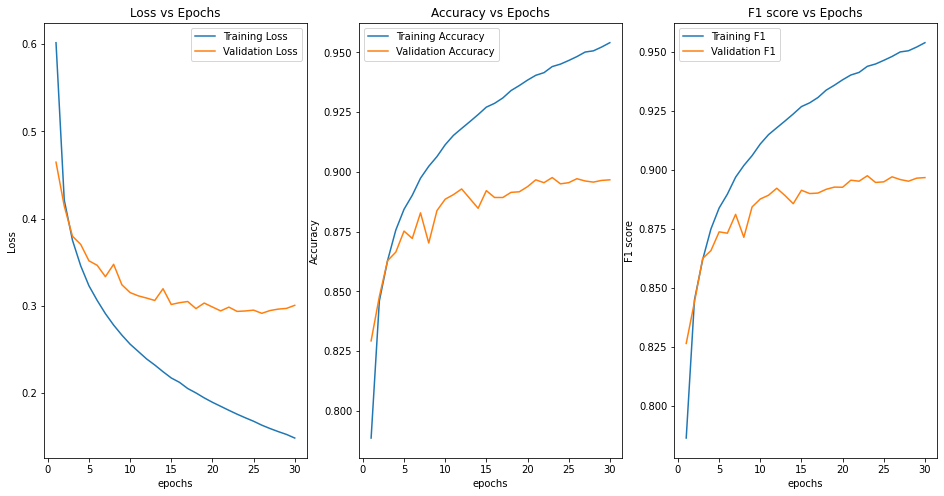

Loading model at epoch 23 for best validation f1
Preparing test loaders
Result on labelled test set  : Loss: 0.3275 Accuracy: 0.8856 F1_score: 0.8856
Result on unlabelled test set: Loss: 10.4008 Accuracy: 0.0000 F1_score: 0.0000
Result on full test set      : Loss: 3.3507 Accuracy: 0.6199 F1_score: 0.5362


In [5]:
whole_flow(6, False)

## Baseline #2, use full Fashion-MNIST dataset to train

Getting train and validate dataloaders for mode 7: use full FasionMNIST data
Start Training... Net
Epoch: 1
	Train      - Loss: 0.5461 Accuracy: 0.8171 F1_score: 0.8151
	Validation - Loss: 0.3969 Accuracy: 0.8570 F1_score: 0.8567
Epoch: 2
	Train      - Loss: 0.3590 Accuracy: 0.8741 F1_score: 0.8734
	Validation - Loss: 0.3506 Accuracy: 0.8767 F1_score: 0.8749
Epoch: 3
	Train      - Loss: 0.3179 Accuracy: 0.8893 F1_score: 0.8887
	Validation - Loss: 0.3255 Accuracy: 0.8865 F1_score: 0.8860
Epoch: 4
	Train      - Loss: 0.2926 Accuracy: 0.8984 F1_score: 0.8979
	Validation - Loss: 0.3139 Accuracy: 0.8907 F1_score: 0.8892
Epoch: 5
	Train      - Loss: 0.2734 Accuracy: 0.9055 F1_score: 0.9051
	Validation - Loss: 0.3008 Accuracy: 0.8922 F1_score: 0.8916
Epoch: 6
	Train      - Loss: 0.2582 Accuracy: 0.9104 F1_score: 0.9100
	Validation - Loss: 0.2939 Accuracy: 0.8930 F1_score: 0.8930
Epoch: 7
	Train      - Loss: 0.2456 Accuracy: 0.9153 F1_score: 0.9150
	Validation - Loss: 0.2856 Accuracy: 0.9003 F

<Figure size 432x288 with 0 Axes>

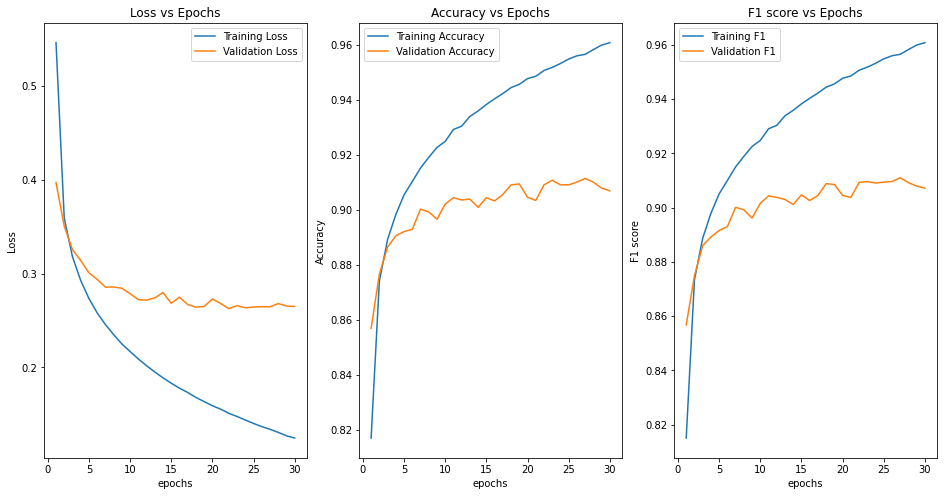

Loading model at epoch 27 for best validation f1
Preparing test loaders
Result on labelled test set  : Loss: 0.3431 Accuracy: 0.8801 F1_score: 0.8843
Result on unlabelled test set: Loss: 0.0965 Accuracy: 0.9697 F1_score: 0.9762
Result on full test set      : Loss: 0.2685 Accuracy: 0.9070 F1_score: 0.9073


In [6]:
whole_flow(7, False)

# Label new categories by clustering

- label the dataset under different clustering methods
- compare acuracy on the test set

## Approach #1, use KMeans to compute label for unlabelled data

Getting train and validate dataloaders for mode 0: clustering: kmeans
Labeling unlabeled data...
Labeling accuracy: 0.8799444444444444
Start Training... Net
Epoch: 1
	Train      - Loss: 0.5487 Accuracy: 0.8142 F1_score: 0.8117
	Validation - Loss: 0.3990 Accuracy: 0.8655 F1_score: 0.8655
Epoch: 2
	Train      - Loss: 0.3674 Accuracy: 0.8707 F1_score: 0.8698
	Validation - Loss: 0.3485 Accuracy: 0.8823 F1_score: 0.8816
Epoch: 3
	Train      - Loss: 0.3271 Accuracy: 0.8839 F1_score: 0.8832
	Validation - Loss: 0.3277 Accuracy: 0.8890 F1_score: 0.8885
Epoch: 4
	Train      - Loss: 0.3007 Accuracy: 0.8944 F1_score: 0.8938
	Validation - Loss: 0.3096 Accuracy: 0.8918 F1_score: 0.8913
Epoch: 5
	Train      - Loss: 0.2816 Accuracy: 0.9008 F1_score: 0.9003
	Validation - Loss: 0.3048 Accuracy: 0.8928 F1_score: 0.8924
Epoch: 6
	Train      - Loss: 0.2654 Accuracy: 0.9084 F1_score: 0.9080
	Validation - Loss: 0.2928 Accuracy: 0.8970 F1_score: 0.8974
Epoch: 7
	Train      - Loss: 0.2520 Accuracy: 0.9129 F1_s

<Figure size 432x288 with 0 Axes>

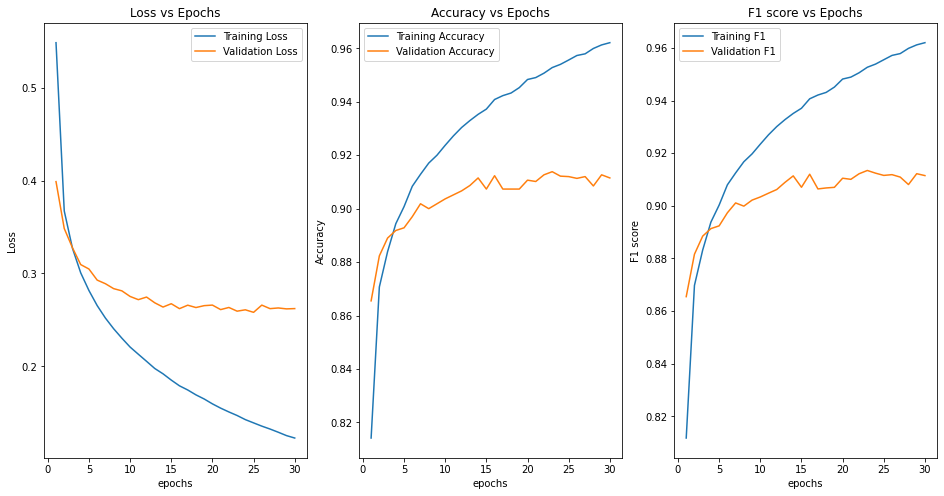

Loading model at epoch 23 for best validation f1
Preparing test loaders
Result on labelled test set  : Loss: 0.3499 Accuracy: 0.8784 F1_score: 0.8829
Result on unlabelled test set: Loss: 0.7429 Accuracy: 0.8683 F1_score: 0.8772
Result on full test set      : Loss: 0.4662 Accuracy: 0.8754 F1_score: 0.8763


In [7]:
whole_flow(0, False)

## Approach #2, use KMeans with PCA to compute label for unlabelled data

Getting train and validate dataloaders for mode 1: clustering: kmeans with PCA
Labeling unlabeled data...
Labeling accuracy: 0.881
Start Training... Net
Epoch: 1
	Train      - Loss: 0.5396 Accuracy: 0.8181 F1_score: 0.8158
	Validation - Loss: 0.3972 Accuracy: 0.8630 F1_score: 0.8629
Epoch: 2
	Train      - Loss: 0.3599 Accuracy: 0.8724 F1_score: 0.8715
	Validation - Loss: 0.3537 Accuracy: 0.8777 F1_score: 0.8788
Epoch: 3
	Train      - Loss: 0.3186 Accuracy: 0.8882 F1_score: 0.8876
	Validation - Loss: 0.3272 Accuracy: 0.8848 F1_score: 0.8838
Epoch: 4
	Train      - Loss: 0.2924 Accuracy: 0.8971 F1_score: 0.8966
	Validation - Loss: 0.3115 Accuracy: 0.8925 F1_score: 0.8929
Epoch: 5
	Train      - Loss: 0.2741 Accuracy: 0.9040 F1_score: 0.9035
	Validation - Loss: 0.3011 Accuracy: 0.8958 F1_score: 0.8948
Epoch: 6
	Train      - Loss: 0.2592 Accuracy: 0.9095 F1_score: 0.9092
	Validation - Loss: 0.2990 Accuracy: 0.8957 F1_score: 0.8951
Epoch: 7
	Train      - Loss: 0.2458 Accuracy: 0.9147 F1_score

<Figure size 432x288 with 0 Axes>

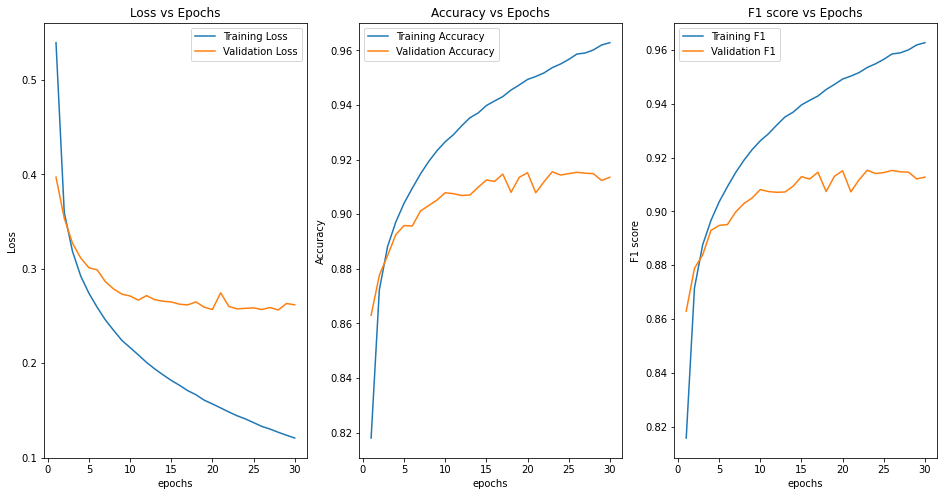

Loading model at epoch 23 for best validation f1
Preparing test loaders
Result on labelled test set  : Loss: 0.3549 Accuracy: 0.8773 F1_score: 0.8808
Result on unlabelled test set: Loss: 0.7100 Accuracy: 0.8773 F1_score: 0.8850
Result on full test set      : Loss: 0.4614 Accuracy: 0.8773 F1_score: 0.8769


In [8]:
whole_flow(1, False)

## Approach #3, use KMeans with Auto Encoder to compute label for unlabelled data

Getting train and validate dataloaders for mode 2: clustering: kmeans with Auto Encoder
Labeling unlabeled data...
Training Auto Encoder...


/ssd/jason_ssd/AdaptToNewClass/mylibs/loss.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  log2pi = torch.log(torch.tensor(2.0 * torch.as_tensor(np.pi)))
/ssd/jason_ssd/AdaptToNewClass/mylibs/loss.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.sum(-0.5 * ((sample - mean) ** 2.0 * torch.exp(torch.tensor(-logvar)) + logvar + log2pi), dim=raxis)


Epoch: 1 Loss: {'loss': 354.99633662109375}
Epoch: 2 Loss: {'loss': 320.9731922526042}
Epoch: 3 Loss: {'loss': 317.61745400390623}
Epoch: 4 Loss: {'loss': 316.3578083170573}
Epoch: 5 Loss: {'loss': 315.8289954264323}
Epoch: 6 Loss: {'loss': 315.3753229329427}
Epoch: 7 Loss: {'loss': 315.15972548828125}
Epoch: 8 Loss: {'loss': 314.9283509440104}
Epoch: 9 Loss: {'loss': 314.51958159179685}
Epoch: 10 Loss: {'loss': 314.3853491210937}
Epoch: 11 Loss: {'loss': 314.3160645345052}
Epoch: 12 Loss: {'loss': 314.3321009440104}
Epoch: 13 Loss: {'loss': 314.1502100260417}
Epoch: 14 Loss: {'loss': 313.933809000651}
Epoch: 15 Loss: {'loss': 314.0860360514323}
Labeling accuracy: 0.34144444444444444
Start Training... Net
Epoch: 1
	Train      - Loss: 0.7237 Accuracy: 0.7126 F1_score: 0.6883
	Validation - Loss: 0.5872 Accuracy: 0.7493 F1_score: 0.7264
Epoch: 2
	Train      - Loss: 0.5523 Accuracy: 0.7656 F1_score: 0.7425
	Validation - Loss: 0.5450 Accuracy: 0.7708 F1_score: 0.7341
Epoch: 3
	Train      - 

<Figure size 432x288 with 0 Axes>

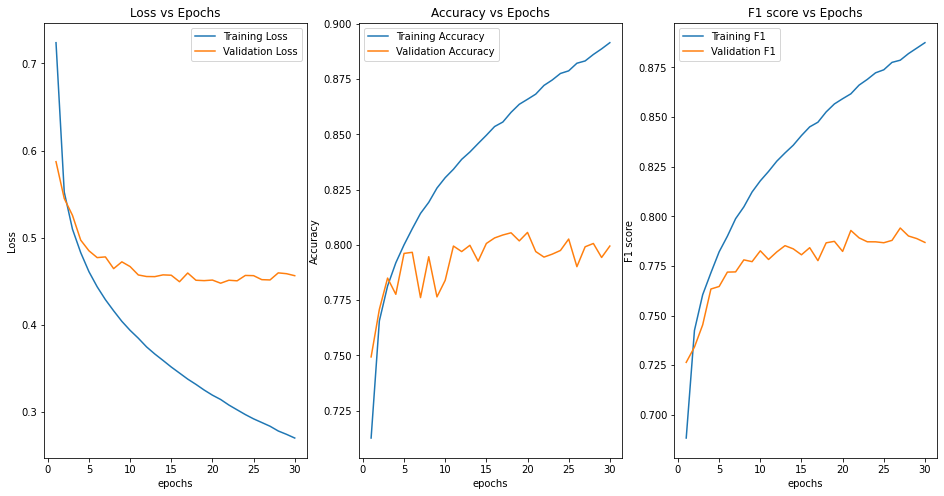

Loading model at epoch 27 for best validation f1
Preparing test loaders
Result on labelled test set  : Loss: 0.3618 Accuracy: 0.8753 F1_score: 0.8790
Result on unlabelled test set: Loss: 4.3273 Accuracy: 0.3537 F1_score: 0.2550
Result on full test set      : Loss: 1.5523 Accuracy: 0.7188 F1_score: 0.6891


In [9]:
whole_flow(2, False)

## Approach #4, use Gaussian Mixture to compute label for unlabelled data

Getting train and validate dataloaders for mode 3: clustering: Gaussian Mixture
Labeling unlabeled data...
Labeling accuracy: 0.8328888888888889
Start Training... Net
Epoch: 1
	Train      - Loss: 0.5408 Accuracy: 0.8182 F1_score: 0.8165
	Validation - Loss: 0.3846 Accuracy: 0.8645 F1_score: 0.8635
Epoch: 2
	Train      - Loss: 0.3572 Accuracy: 0.8735 F1_score: 0.8727
	Validation - Loss: 0.3376 Accuracy: 0.8792 F1_score: 0.8780
Epoch: 3
	Train      - Loss: 0.3163 Accuracy: 0.8889 F1_score: 0.8883
	Validation - Loss: 0.3138 Accuracy: 0.8890 F1_score: 0.8887
Epoch: 4
	Train      - Loss: 0.2913 Accuracy: 0.8976 F1_score: 0.8971
	Validation - Loss: 0.3003 Accuracy: 0.8943 F1_score: 0.8943
Epoch: 5
	Train      - Loss: 0.2722 Accuracy: 0.9046 F1_score: 0.9041
	Validation - Loss: 0.2858 Accuracy: 0.8965 F1_score: 0.8961
Epoch: 6
	Train      - Loss: 0.2572 Accuracy: 0.9095 F1_score: 0.9092
	Validation - Loss: 0.2879 Accuracy: 0.8960 F1_score: 0.8968
Epoch: 7
	Train      - Loss: 0.2439 Accuracy: 0

<Figure size 432x288 with 0 Axes>

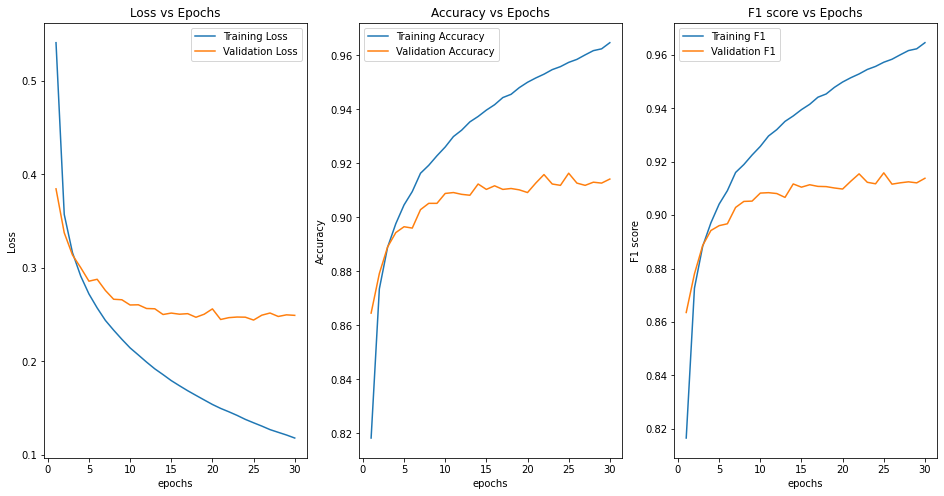

Loading model at epoch 25 for best validation f1
Preparing test loaders
Result on labelled test set  : Loss: 0.3434 Accuracy: 0.8786 F1_score: 0.8819
Result on unlabelled test set: Loss: 1.3362 Accuracy: 0.8250 F1_score: 0.8280
Result on full test set      : Loss: 0.6390 Accuracy: 0.8625 F1_score: 0.8614


In [10]:
whole_flow(3, False)

## Approach #5, use Gaussian Mixture with PCA to compute label for unlabelled data

Getting train and validate dataloaders for mode 4: clustering: Gaussian Mixture with PCA
Labeling unlabeled data...
Labeling accuracy: 0.6936666666666667
Start Training... Net
Epoch: 1
	Train      - Loss: 0.5484 Accuracy: 0.8143 F1_score: 0.8121
	Validation - Loss: 0.4202 Accuracy: 0.8547 F1_score: 0.8548
Epoch: 2
	Train      - Loss: 0.3578 Accuracy: 0.8725 F1_score: 0.8717
	Validation - Loss: 0.3658 Accuracy: 0.8760 F1_score: 0.8756
Epoch: 3
	Train      - Loss: 0.3155 Accuracy: 0.8878 F1_score: 0.8873
	Validation - Loss: 0.3413 Accuracy: 0.8823 F1_score: 0.8818
Epoch: 4
	Train      - Loss: 0.2890 Accuracy: 0.8979 F1_score: 0.8974
	Validation - Loss: 0.3293 Accuracy: 0.8845 F1_score: 0.8851
Epoch: 5
	Train      - Loss: 0.2710 Accuracy: 0.9046 F1_score: 0.9042
	Validation - Loss: 0.3158 Accuracy: 0.8902 F1_score: 0.8896
Epoch: 6
	Train      - Loss: 0.2559 Accuracy: 0.9114 F1_score: 0.9110
	Validation - Loss: 0.3187 Accuracy: 0.8898 F1_score: 0.8887
Epoch: 7
	Train      - Loss: 0.2428 Ac

<Figure size 432x288 with 0 Axes>

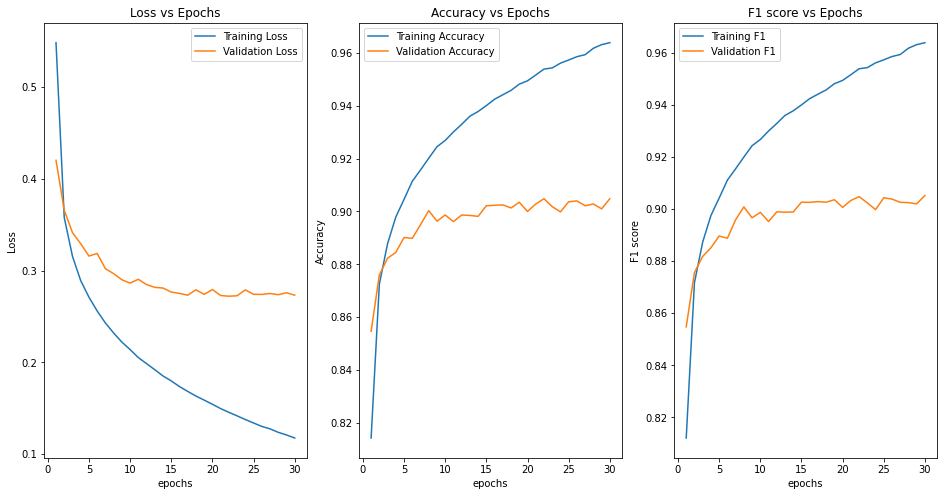

Loading model at epoch 30 for best validation f1
Preparing test loaders
Result on labelled test set  : Loss: 0.3369 Accuracy: 0.8830 F1_score: 0.8866
Result on unlabelled test set: Loss: 3.3661 Accuracy: 0.6863 F1_score: 0.6731
Result on full test set      : Loss: 1.2560 Accuracy: 0.8240 F1_score: 0.8191


In [11]:
whole_flow(4, False)

## Approach #6, use Gaussian Mixture with Auto Encoder to compute label for unlabelled data

Getting train and validate dataloaders for mode 5: clustering: Gaussian Mixture with Auto Encoder
Labeling unlabeled data...
Training Auto Encoder...


/ssd/jason_ssd/AdaptToNewClass/mylibs/loss.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  log2pi = torch.log(torch.tensor(2.0 * torch.as_tensor(np.pi)))
/ssd/jason_ssd/AdaptToNewClass/mylibs/loss.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.sum(-0.5 * ((sample - mean) ** 2.0 * torch.exp(torch.tensor(-logvar)) + logvar + log2pi), dim=raxis)


Epoch: 1 Loss: {'loss': 350.63329381510414}
Epoch: 2 Loss: {'loss': 320.8765460286458}
Epoch: 3 Loss: {'loss': 318.0106686035156}
Epoch: 4 Loss: {'loss': 316.85074409179686}
Epoch: 5 Loss: {'loss': 316.06245032552084}
Epoch: 6 Loss: {'loss': 315.8215092447917}
Epoch: 7 Loss: {'loss': 315.41061326497396}
Epoch: 8 Loss: {'loss': 315.20511927083334}
Epoch: 9 Loss: {'loss': 314.94296461588544}
Epoch: 10 Loss: {'loss': 314.7985603515625}
Epoch: 11 Loss: {'loss': 314.5215768066406}
Epoch: 12 Loss: {'loss': 314.42062470703127}
Epoch: 13 Loss: {'loss': 314.28416712239584}
Epoch: 14 Loss: {'loss': 314.1716448079427}
Epoch: 15 Loss: {'loss': 314.07801852213544}
Labeling accuracy: 0.3381111111111111
Start Training... Net
Epoch: 1
	Train      - Loss: 0.8468 Accuracy: 0.6556 F1_score: 0.6359
	Validation - Loss: 0.7252 Accuracy: 0.6883 F1_score: 0.6410
Epoch: 2
	Train      - Loss: 0.6757 Accuracy: 0.7062 F1_score: 0.6881
	Validation - Loss: 0.6718 Accuracy: 0.6845 F1_score: 0.6809
Epoch: 3
	Train   

<Figure size 432x288 with 0 Axes>

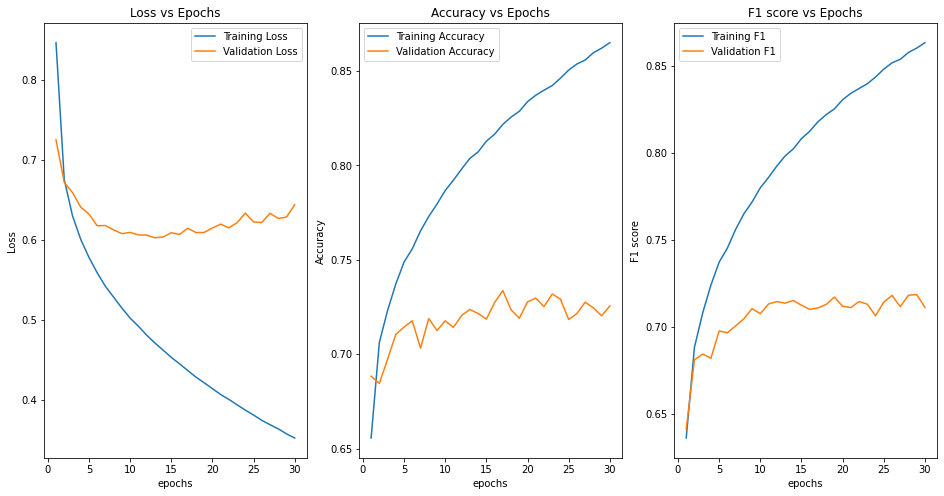

Loading model at epoch 29 for best validation f1
Preparing test loaders
Result on labelled test set  : Loss: 0.3594 Accuracy: 0.8769 F1_score: 0.8816
Result on unlabelled test set: Loss: 1.3512 Accuracy: 0.3557 F1_score: 0.3060
Result on full test set      : Loss: 0.6554 Accuracy: 0.7205 F1_score: 0.7052


In [12]:
whole_flow(5, False)

## Summarys

<Figure size 432x288 with 0 Axes>

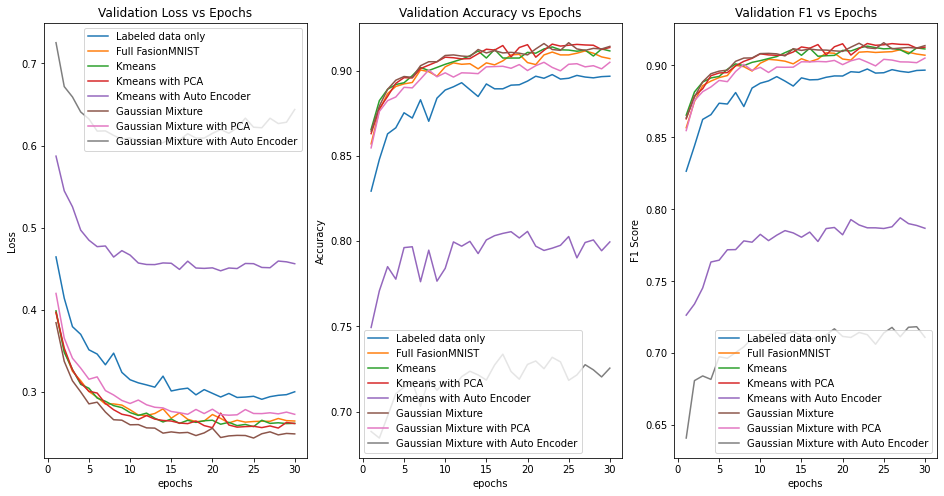

In [13]:
report_summary(mode_metrics, mode_description_short)

<Figure size 432x288 with 0 Axes>

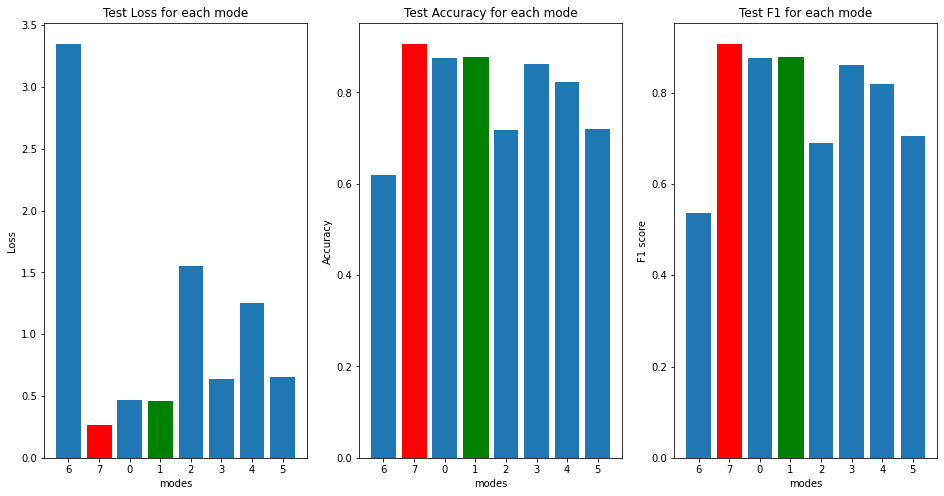

Mode Interpretations: 
    6: Labeled data only
    7: Full FasionMNIST
    0: Kmeans
    1: Kmeans with PCA
    2: Kmeans with Auto Encoder
    3: Gaussian Mixture
    4: Gaussian Mixture with PCA
    5: Gaussian Mixture with Auto Encoder
Color Interpretations: 
    Red  : Best result over all runs
    Green: Best result over all approachs (excluding baselines)


In [18]:
report_test_summary(mode_test_metrics, mode_description_short)

In [27]:
clustering_acc()

- Unsupervised Clusteriing on the full test set:
Labeling unlabeled data...
Labeling accuracy: 0.5603
- Unsupervised Clusteriing on the labelled test set:
Labeling unlabeled data...
Labeling accuracy: 0.551
- Unsupervised Clusteriing on the unlabelled test set:
Labeling unlabeled data...
Labeling accuracy: 0.8876666666666667


|                  Method              | Test Loss on Labeled Data | Test Accuracy on Labeled Data | Test F1 on Labeled Data | Test Loss on Unlabeled Data | Test Accuracy on Unlabeled Data | Test F1 on Unlabeled Data | Test Loss on All Data | Test Accuracy on All Data | Test F1 on All Data |
| ------------------------------------ | --------- | ------------- | ------- |------- |------- |------- |------- |------- |------- |
|  Baseline 1 - Only use Labeled data  |0.3275     | 0.8856        | 0.8856  |10.4008    | 0.0000        | 0.0000  | 3.3507 | 0.6199 | 0.5362
|                  KMeans              |0.3499     | 0.8784        | 0.8829  |0.7429    | 0.8683        | 0.8772  | 0.4662 | 0.8754 | 0.8763 
|            KMeans with PCA           |0.3549     | 0.8773        | 0.8808  |0.7100    | 0.8773        | 0.8850  | 0.4614 | 0.8773 | 0.8769
|            KMeans with VAE           |0.3618     | 0.8753        | 0.8790  |4.3273    | 0.3537        | 0.2550  | 1.5523 | 0.7188 | 0.6891
|            Gaussian Mixture          |0.3434     | 0.8786        | 0.8819  |1.3362    | 0.8250        | 0.8280  | 0.6390 | 0.8625 | 0.8614
|        Gaussian Mixture with PCA     |0.3369     | 0.8830        | 0.8866  |3.3661    | 0.6863        | 0.6731  | 1.2560 | 0.8240 | 0.8191
|        Gaussian Mixture with VAE     |0.3594     | 0.8769        | 0.8816  |1.3512    | 0.3557        | 0.3060  | 0.6554 | 0.7205 | 0.7052
|  Baseline 2 - Full FashionMNIST data |0.3431     | 0.8801        | 0.8843  |0.0965    | 0.9697        | 0.9762  | 0.2685 | 0.9070 | 0.9073
| Unsupervised Clustering | N/A | 0.551 | N/A | N/A | 0.8876 | N/A | N/A | 0.5603 | N/A |

## Conclusion

We implement two clustering algorithms - KMeans and GaussianMixture, along with additional improvements - Principal Component Analysis and Variational Auto Encoder. Our implementation of VAE failed to properly encode the images. However, we can still see that without proper labeling, the overall model was still better than the one trained with only accurate labeled data and the unsupervised clustering. We can from here conclude that neural networks do not generalize to unseen data well or even at all, as we can see from the above table that when trained without certain labels, the model cannot recognize them at all (0 accuracy). 

The model trained with only pre-labeled data has 60% accuracy among the full test set, which is a little better than the unsupervised clustering method with a 56% accuracy (the best is Kmean). The model trained with pre-labeled data is extremely bad on the unlabeled part of the test set. The accuracy of models trained with dataset combined by pre-labeled data and clustering labeled data are vary from 72% to 88%, which is getting close to the baseline2. Baseline2 is the best result with 91% accuracy. Fully labeled dataset is much accurate than the clustering labeled dataset. Thus, the best model is trained with the fully labeled one.

Among the methods we implemented, we see that KMeans generally performs slightly better than Gaussian Mixture. This is likely because of the properties of the dataset, where the clusters have clear decision boundaries. Principal Component Analysis can slightly improve the performance of the clustering labeling, but overall it doesn't affect the training result much.